## 1. About the DWD Open Data Portal 

The data of the Climate Data Center (CDC) of the DWD (Deutscher Wetterdienst, German Weather Service) is provided on an **FTP server**. <br> **FTP** stands for _File Transfer Protocol_.

Open the FTP link ftp://opendata.dwd.de/climate_environment/CDC/ in your browser (copy-paste) and find our how it is structured hierarchically.

You can also open the link with **HTTPS** (Hypertext Transfer Protocol Secure): https://opendata.dwd.de/climate_environment/CDC/

We are interested in downloading the metadata of daily precipitation to get information related to their stations

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import re # to use regex expressions 
import tqdm
import pandas as pd
import geopandas as gpd

# URL of the DWD website
url_base = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/"
url_temporal_resolution = "daily/"
url_parameter = "more_precip/"
url_subdir = "historical/"
url_full = os.path.join(url_base, url_temporal_resolution, url_parameter, url_subdir)

# Directory to save the downloaded files
download_dir = "../data/original/dwd/" +  url_temporal_resolution + url_parameter + url_subdir

# Create the directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

print("download dir: ", download_dir)

# Directory and name to save the CSV file to create the layer for sub-task 1.2
outfname = r"../data/Selected_Stations_Nordrhein_Westfalen.csv"

download dir:  ../data/original/dwd/daily/more_precip/historical/


In [2]:
url_full

'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/more_precip/historical/'

In [3]:
def grab_file(file_url, download_dir):
        # get only the file name from the full url
        file_name = file_url.split("/")[-1]
        # Download the file
        file_path =os.path.join(download_dir, file_name)
        with open(file_path, "wb") as file:
            file.write(requests.get(file_url).content)
        
    

In [4]:
# Send an HTTP request to the URL
response = requests.get(url_full)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, "html.parser")
    # Look for the metadata file
    links = soup.find_all(href=re.compile("Beschreibung"))
    # Take the url of the file
    file_name = links[0].get("href")
    # Download the file
    grab_file(os.path.join(url_full, file_name), download_dir)
    print(f"Downloaded: {download_dir+file_name}")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")

Downloaded: ../data/original/dwd/daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt


In [5]:
# get station path
file_path = os.path.join(download_dir,file_name)
# read the header of the file
header = open(file_path, encoding="latin").readline().split()
header

['Stations_id',
 'von_datum',
 'bis_datum',
 'Stationshoehe',
 'geoBreite',
 'geoLaenge',
 'Stationsname',
 'Bundesland',
 'Abgabe']

In [6]:
# translation dictionary
translate = \
{'Stations_id':'station_id',
 'von_datum':'date_from',
 'bis_datum':'date_to',
 'Stationshoehe':'altitude',
 'geoBreite': 'latitude',
 'geoLaenge': 'longitude',
 'Stationsname':'name',
 'Bundesland':'state'}

In [7]:
#pd.read_csv?

In [8]:
df_stations_2 = pd.read_fwf(file_path,
                          skiprows=[0,1],
                          names=translate,
                          encoding="latin", 
                          parse_dates=["von_datum","bis_datum"],
                          dtype={"Stations_id":str}
                          #index_col="Stations_id"
                         )
df_stations_2

C:\Users\amr_d\AppData\Local\Temp\ipykernel_21340\2950410865.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_stations_2 = pd.read_fwf(file_path,


,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
1,19120101,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg,Frei
2,19510101,2006-12-31,138,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen,Frei
3,18910101,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,Frei
4,19510101,1979-10-31,243,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen,Frei
6,19821101,2024-09-21,455,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg,Frei
...,...,...,...,...,...,...,...,...
19898,20240101,2024-09-21,39,52.4970,13.2820,Berlin-Halensee,Berlin,Frei
19911,19631101,1986-09-30,215,50.9625,10.0663,Gerstungen/Thüringen,Thüringen,Frei
19917,20240325,2024-09-21,153,49.9321,8.0767,Schwabenheim a.d. Selz,Rheinland-Pfalz,NaN
19993,18970507,1935-12-31,4,53.6870,9.6757,Uetersen,Schleswig-Holstein,Frei


In [9]:
# read the stations dataframe
df_stations = pd.read_fwf(file_path,
                          skiprows=2,
                          names=header,
                          encoding="latin", 
                          parse_dates=["von_datum","bis_datum"],
                          dtype={"Stations_id":str}
                          #index_col="Stations_id"
                         )
df_stations

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Abgabe
0,00001,1912-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg,Frei
1,00002,1951-01-01,2006-12-31,138,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen,Frei
2,00003,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,Frei
3,00004,1951-01-01,1979-10-31,243,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen,Frei
4,00006,1982-11-01,2024-09-21,455,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg,Frei
...,...,...,...,...,...,...,...,...,...
6487,19898,2024-01-01,2024-09-21,39,52.4970,13.2820,Berlin-Halensee,Berlin,Frei
6488,19911,1963-11-01,1986-09-30,215,50.9625,10.0663,Gerstungen/Thüringen,Thüringen,Frei
6489,19917,2024-03-25,2024-09-21,153,49.9321,8.0767,Schwabenheim a.d. Selz,Rheinland-Pfalz,NaN
6490,19993,1897-05-07,1935-12-31,4,53.6870,9.6757,Uetersen,Schleswig-Holstein,Frei


Check all the different values in the "state" column. You can use the function <code>.unique()</code> for this.

In [10]:
df_stations.rename(columns=translate,inplace=True)

In [11]:
df_stations.loc[:,"state"].unique()

array(['Baden-Württemberg', 'Nordrhein-Westfalen', 'Hessen', 'Bayern',
       'Niedersachsen', 'Sachsen-Anhalt', 'Rheinland-Pfalz', 'Sachsen',
       'Mecklenburg-Vorpommern', 'Schleswig-Holstein', 'Brandenburg',
       'Thüringen', 'Saarland', 'Berlin', 'Bremen', 'Hamburg', 'Tirol'],
      dtype=object)

Select only stations in NRW which are still active (date_to is later than 2023) and which starting recording information at least in 1950.

In [12]:
#df_stations.query?

In [13]:
# filter stations only in Nordrhein-Westfalen which are active and older than 1950
df_stations_short = df_stations.query("state == 'Nordrhein-Westfalen' and date_to >= 2023 and date_from < 1950")

In [14]:
df_stations_short

,station_id,date_from,date_to,altitude,latitude,longitude,name,state,Abgabe
75,00079,1931-01-01,2024-09-20,160,50.6718,7.0155,Alfter-Volmershoven,Nordrhein-Westfalen,Frei
104,00110,1931-01-01,2024-09-21,65,52.0487,7.4877,Altenberge,Nordrhein-Westfalen,Frei
174,00187,1941-01-01,2024-09-21,265,51.4188,7.9126,Arnsberg-Holzen,Nordrhein-Westfalen,Frei
292,00325,1941-01-01,2024-09-21,127,51.7948,8.0718,Beckum-Vellern,Nordrhein-Westfalen,Frei
349,00389,1931-01-01,2024-09-21,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen,Frei
...,...,...,...,...,...,...,...,...,...
5104,05579,1941-01-01,2024-09-21,273,51.5892,9.0296,Willebadessen-Borlinghausen,Nordrhein-Westfalen,Frei
5143,05619,1931-01-01,2024-09-21,360,51.1637,7.4234,Wipperfürth-Gardeweg,Nordrhein-Westfalen,Frei
5218,05699,1941-01-01,2024-09-21,312,51.5427,8.7784,Wünnenberg-Eilern,Nordrhein-Westfalen,Frei
5236,05717,1937-01-01,2024-09-21,134,51.2256,7.1052,Wuppertal-Buchenhofen,Nordrhein-Westfalen,Frei


In [15]:
# get the links. 
links = soup.find_all(href=[re.compile("RR_"+x) for x in df_stations_short.loc[:,"station_id"]])
links



[<a href="tageswerte_RR_00079_19310101_20231231_hist.zip">tageswerte_RR_00079_19310101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00110_19310101_20231231_hist.zip">tageswerte_RR_00110_19310101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00187_19410101_20231231_hist.zip">tageswerte_RR_00187_19410101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00325_19410101_20231231_hist.zip">tageswerte_RR_00325_19410101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00389_19310101_20231231_hist.zip">tageswerte_RR_00389_19310101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00488_19410101_20231231_hist.zip">tageswerte_RR_00488_19410101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00554_19460101_20231231_hist.zip">tageswerte_RR_00554_19460101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00555_19310101_20231231_hist.zip">tageswerte_RR_00555_19310101_20231231_hist.zip</a>,
 <a href="tageswerte_RR_00613_19410101_20231231_hist.zip">tageswerte_RR_00613_19410101_20231231_hist.zip</a>,
 <a href="

In [16]:
#soup

In [17]:
try:
    # iterate through the list
    for link in tqdm.tqdm(links):
        # Take the url of the file
        file_name = link.get("href")
        # Download the file
        grab_file(os.path.join(url_full, file_name), download_dir)
    
except:
    print("Failed to download")

print("Download complete")

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:32<00:00,  2.59it/s]

Download complete


extract one of the zip files to look at the content. Identify which file contains the data you are interested in.

In [18]:
import glob
zip_list = glob.glob(download_dir+"*.zip")
zip_list

['../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00079_19310101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00110_19310101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00187_19410101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00325_19410101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00389_19310101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00488_19410101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00554_19460101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00555_19310101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00613_19410101_20231231_hist.zip',
 '../data/original/dwd/daily/more_precip/historical\\tageswerte_RR_00617_19410101_

In [19]:
from zipfile import ZipFile
# example of the files inside the first zip file
with ZipFile(zip_list[0]) as myzip:
    print(myzip.namelist())

['Metadaten_Stationsname_Betreibername_00079.html', 'Metadaten_Stationsname_Betreibername_00079.txt', 'Metadaten_Parameter_nieder_tag_00079.html', 'Metadaten_Parameter_nieder_tag_00079.txt', 'Metadaten_Geraete_Neuschneehoehe_00079.html', 'Metadaten_Geraete_Neuschneehoehe_00079.txt', 'Metadaten_Geraete_Niederschlagshoehe_00079.html', 'Metadaten_Geraete_Niederschlagshoehe_00079.txt', 'Metadaten_Geraete_Schneehoehe_00079.html', 'Metadaten_Geraete_Schneehoehe_00079.txt', 'Metadaten_Geographie_00079.txt', 'Metadaten_Fehldaten_00079_19310101_20231231.html', 'Metadaten_Fehldaten_00079_19310101_20231231.txt', 'Metadaten_Fehlwerte_00079_19310101_20231231.txt', 'produkt_nieder_tag_19310101_20231231_00079.txt']


In [20]:
# use the name pattern to get the file name
with ZipFile(zip_list[0]) as myzip:
    prod_filename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
    print(prod_filename)

produkt_nieder_tag_19310101_20231231_00079.txt


In [21]:
# Read one of the files as example

with ZipFile(zip_list[0]) as myzip:
    prod_filename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
    
    #open just the product file within archive
    with myzip.open(prod_filename) as myfile:
    # read the time series data in a temporal dataframe
        df_prec = pd.read_csv(myfile, 
                      sep=";", 
                      parse_dates = ["MESS_DATUM"], 
                      index_col = "MESS_DATUM", 
                      na_values = [-999.0],
                    dtype={'STATIONS_ID':str}
                         )
df_prec.head()

,STATIONS_ID,QN_6,RS,RSF,SH_TAG,NSH_TAG,eor
MESS_DATUM,,,,,,,
1931-01-01,79,5,5.8,8.0,NaN,NaN,eor
1931-01-02,79,5,3.3,1.0,NaN,NaN,eor
1931-01-03,79,5,5.4,8.0,NaN,NaN,eor
1931-01-04,79,5,0.2,1.0,NaN,NaN,eor
1931-01-05,79,5,2.0,8.0,NaN,NaN,eor


In [22]:
# # Read one of the files as example

# with ZipFile(zip_list[0]) as myzip:
#     prod_filename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
    
#     #open just the product file within archive
#     with myzip.open(prod_filename) as myfile:
#     # read the time series data in a temporal dataframe
#         df_prec = pd.read_csv(myfile, 
#                       sep=";", 
#                       parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], 
#                       index_col = "MESS_DATUM_BEGINN", 
#                       na_values = [-999.0],
#                     dtype={'STATIONS_ID':str}
#                          )
# df_prec.head()

Now repeat the example with all the files in the ziplist. And join them in a dataframe

In [23]:
df_prec.columns

Index(['STATIONS_ID', 'QN_6', '  RS', ' RSF', 'SH_TAG', 'NSH_TAG', 'eor'], dtype='object')

In [24]:
# create an empty dataFrame to merge the temperature data to
df_prec = pd.DataFrame()
# iterate through the zipfiles
for zip_file in zip_list:
    with ZipFile(zip_file) as myzip:
        #we are only interested in the file starting with 'produkt_'
        prod_filename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
        
        #open just the product file within archive
        with myzip.open(prod_filename) as myfile:
            # read the time series data in a temporal dataframe
            df_dummy = pd.read_csv(myfile, 
                                  sep=";", 
                                  parse_dates = ["MESS_DATUM"], 
                                  index_col = "MESS_DATUM", 
                                  na_values = [-999.0],
                                  dtype={"STATIONS_ID":str}
                                 )
            # Only interested in the daily precipitation height parameter
            prec_series = df_dummy["  RS"].rename(df_dummy["STATIONS_ID"].iloc[0]).to_frame()
            # outer join
            df_prec = pd.merge(df_prec,prec_series,left_index=True, right_index=True, how="outer")

In [25]:
df_prec

,79,110,187,325,389,488,554,555,613,617,...,5271,5360,5483,5486,5513,5579,5619,5699,5717,5791
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1888-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,2.6,0.5,0.9,1.2,0.9,3.7,2.2,0.1,3.8,...,0.5,0.7,1.7,1.6,3.5,0.8,2.0,0.3,2.8,0.0
2023-12-28,0.0,0.2,0.5,3.0,0.0,1.8,1.2,2.2,0.8,1.1,...,4.0,0.8,0.5,3.8,2.9,1.4,1.8,0.2,0.3,0.0
2023-12-29,0.4,11.4,17.5,9.7,17.8,19.6,8.5,7.7,13.6,10.4,...,11.8,18.9,12.5,8.7,7.5,11.6,25.7,11.2,17.6,1.0


In [26]:
df_prec.index.rename(name='day', inplace=True)
df_prec.head()

,79,110,187,325,389,488,554,555,613,617,...,5271,5360,5483,5486,5513,5579,5619,5699,5717,5791
day,,,,,,,,,,,,,,,,,,,,,
1888-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Replace full datetime with day as integer
try:
    df_temp.set_index(df_prec.index.day, inplace= True) # extract day from index as int
except:
    next
df_prec

,79,110,187,325,389,488,554,555,613,617,...,5271,5360,5483,5486,5513,5579,5619,5699,5717,5791
day,,,,,,,,,,,,,,,,,,,,,
1888-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,2.6,0.5,0.9,1.2,0.9,3.7,2.2,0.1,3.8,...,0.5,0.7,1.7,1.6,3.5,0.8,2.0,0.3,2.8,0.0
2023-12-28,0.0,0.2,0.5,3.0,0.0,1.8,1.2,2.2,0.8,1.1,...,4.0,0.8,0.5,3.8,2.9,1.4,1.8,0.2,0.3,0.0
2023-12-29,0.4,11.4,17.5,9.7,17.8,19.6,8.5,7.7,13.6,10.4,...,11.8,18.9,12.5,8.7,7.5,11.6,25.7,11.2,17.6,1.0


In [28]:
type(df_prec.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [29]:
# mean = df_prec[(df_prec.index >= pd.Timestamp(1971,1,1)) & (df_prec.index <= pd.Timestamp(2000,12,31))].mean() # mean annual prec between 1971 and 2000
# mean

In [30]:
mean = df_prec[(df_prec.index.year >= 1971) & (df_prec.index.year <= 2000)].mean() # mean annual temp between 1971 and 2000
mean

  79    1.744671
 110    2.125662
 187    2.477952
 325    2.209527
 389    2.543420
          ...   
5579    2.343353
5619    3.679494
5699    2.223913
5717    3.068206
5791    1.555010
Length: 83, dtype: float64

In [31]:
df_prec_diff = (df_prec - mean)
df_prec_diff

,79,110,187,325,389,488,554,555,613,617,...,5271,5360,5483,5486,5513,5579,5619,5699,5717,5791
day,,,,,,,,,,,,,,,,,,,,,
1888-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,-1.744671,0.474338,-1.977952,-1.309527,-1.34342,-1.598275,1.637406,-0.088694,-1.75264,1.467868,...,-1.558103,-2.191332,-1.868626,-0.494298,1.301533,-1.543353,-1.679494,-1.923913,-0.268206,-1.55501
2023-12-28,-1.744671,-1.925662,-1.977952,0.790473,-2.54342,-0.698275,-0.862594,-0.088694,-1.05264,-1.232132,...,1.941897,-2.091332,-3.068626,1.705702,0.701533,-0.943353,-1.879494,-2.023913,-2.768206,-1.55501
2023-12-29,-1.344671,9.274338,15.022048,7.490473,15.25658,17.101725,6.437406,5.411306,11.74736,8.067868,...,9.741897,16.008668,8.931374,6.605702,5.301533,9.256647,22.020506,8.976087,14.531794,-0.55501


In [32]:
df_prec_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49673 entries, 1888-01-01 to 2023-12-31
Data columns (total 83 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0            79  33222 non-null  float64
 1           110  33206 non-null  float64
 2           187  29581 non-null  float64
 3           325  24530 non-null  float64
 4           389  31465 non-null  float64
 5           488  29585 non-null  float64
 6           554  17543 non-null  float64
 7           555  20922 non-null  float64
 8           613  29545 non-null  float64
 9           617  29576 non-null  float64
 10          644  29340 non-null  float64
 11          796  29343 non-null  float64
 12          871  29584 non-null  float64
 13          902  30770 non-null  float64
 14          989  33238 non-null  float64
 15         1024  32293 non-null  float64
 16         1054  26023 non-null  float64
 17         1232  29523 non-null  float64
 18         1246  27546 non-null  

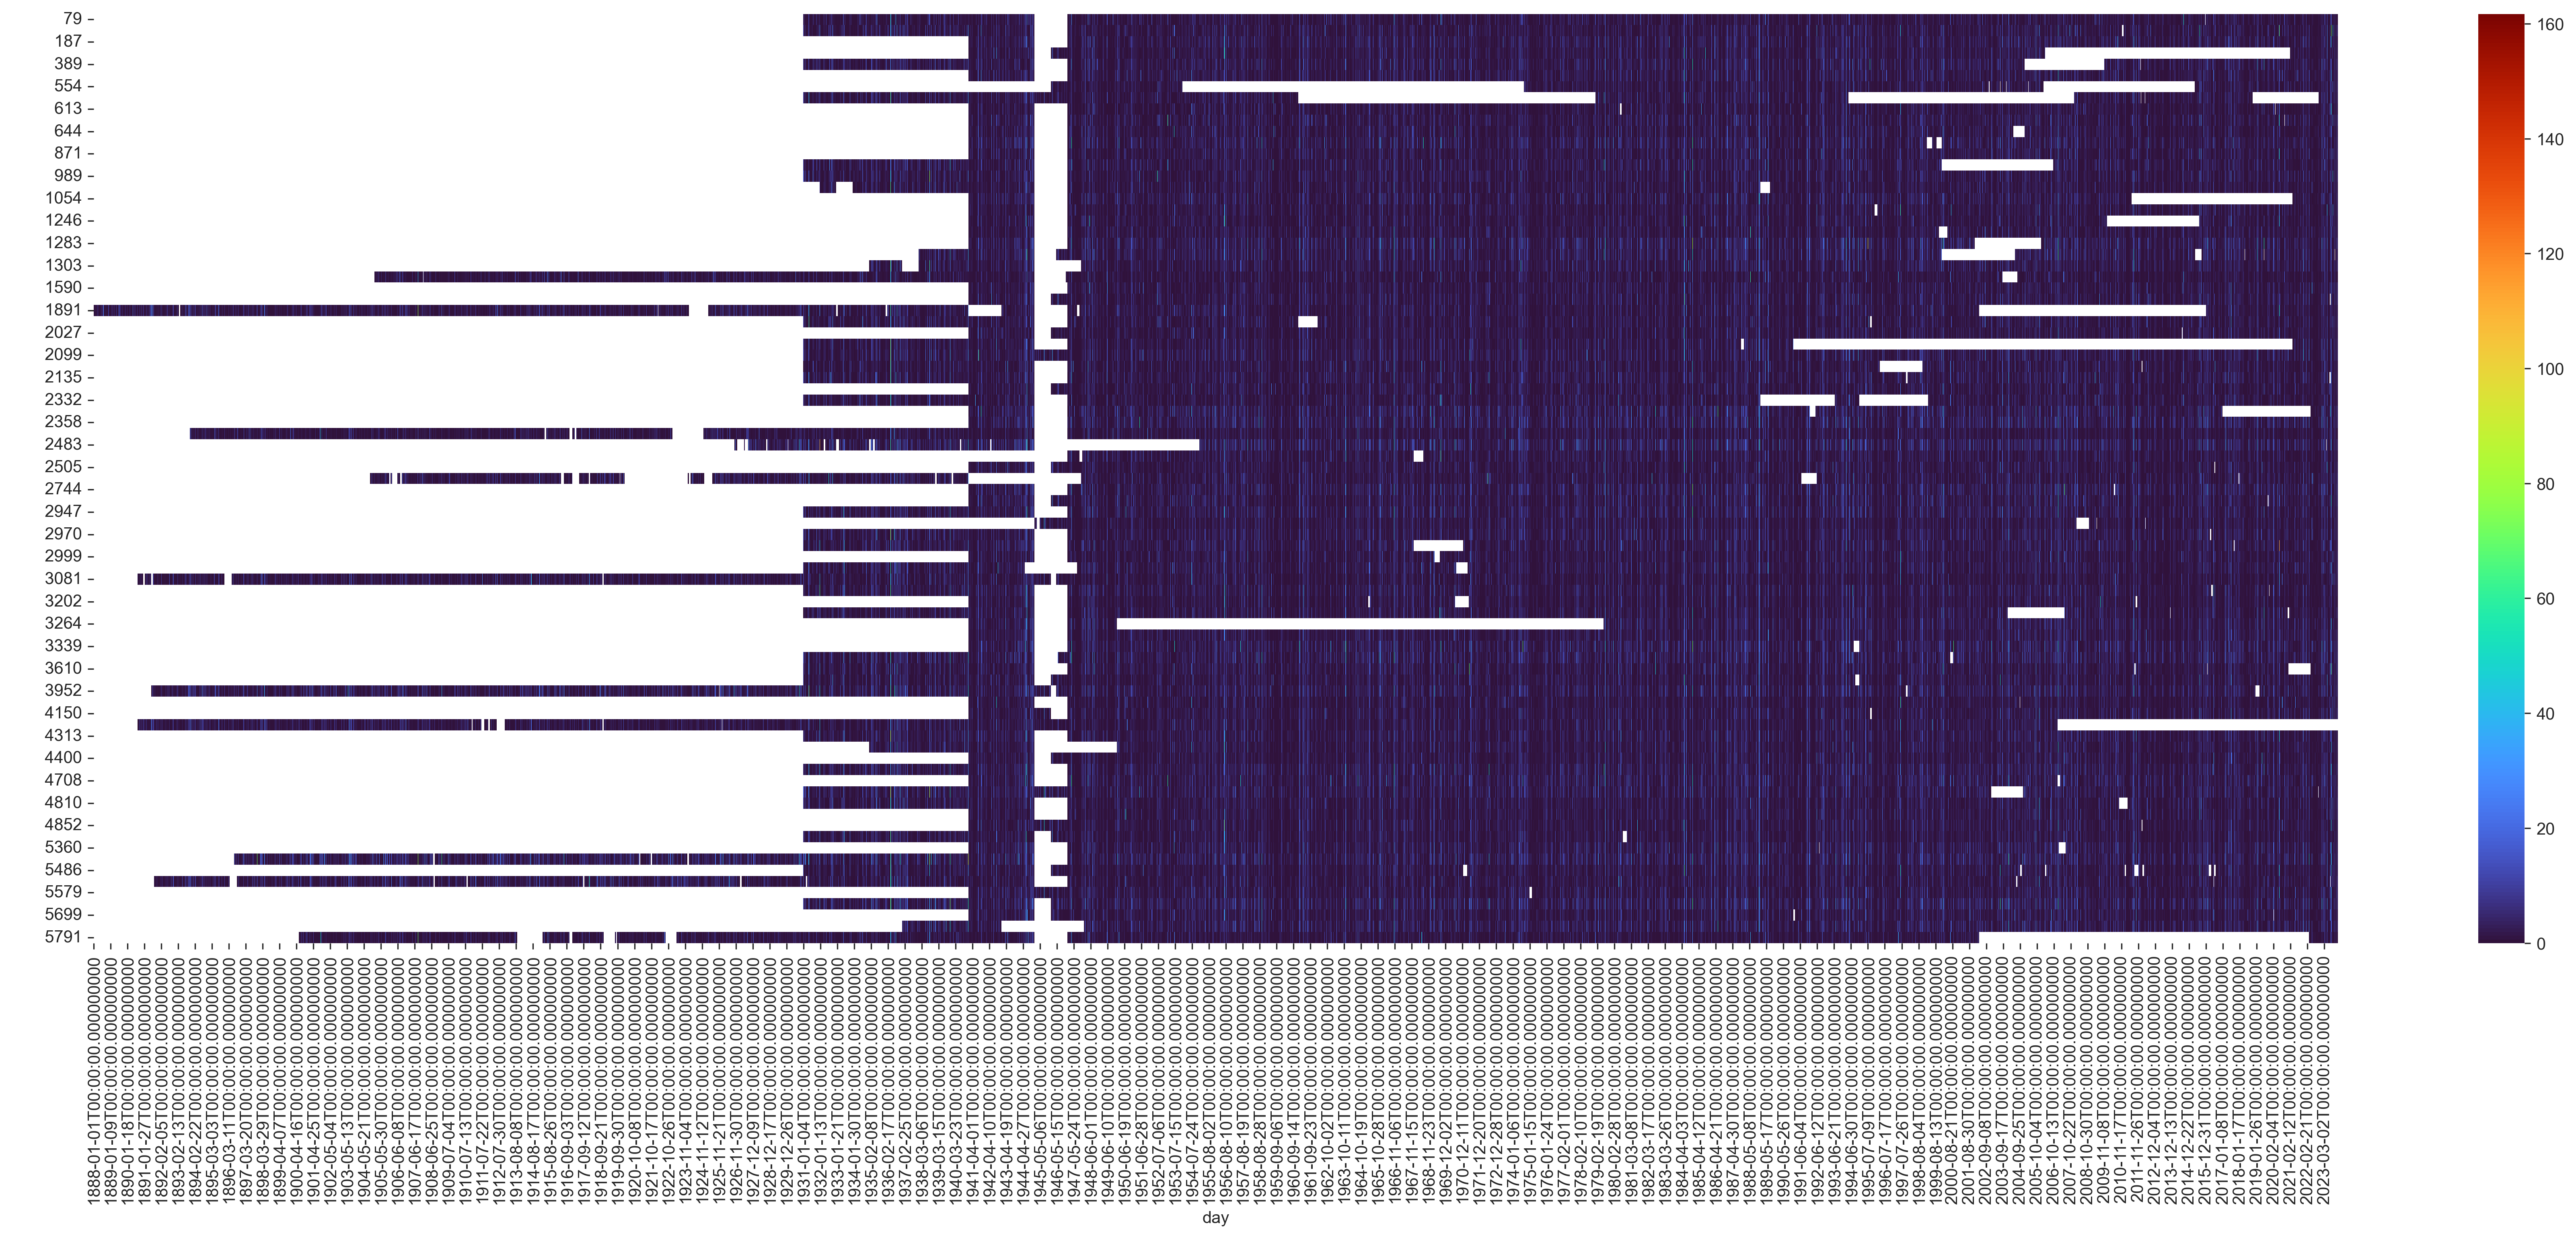

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 300, figsize = (30,10))

sns.heatmap(df_prec.T, cmap='turbo', ax = ax1)
fig1.savefig(r'../Images/Nordrhein_Westfalen_Annual_Prec_Stripes_01.png')

# Exercise
The resolution of the plot above is not optimal. Only one station started getting data from 1851. Remember that you applied a filter to the list of the stations, so it makes sense to only display data within that window of dates.
1) generate a new plot displaying only the measurements from 1950

In [36]:
# plot


# Exercise:
Good! now have a look at the temperature values. Some stations have very cool temperatures all over the series. We can assume that it is an effect of the geographic location, maybe the colder stations are placed at higher altitudes. You can investigate that by looking at your data.

In [37]:
df_stations_short.filter(like="Stations")

""
75
104
174
292
349
...
5104
5143
5218
5236


We are actually interested at the changes in temperature relative to the mean historical measurements.
By plotting the temperatures differences a blue tone means a measurement below the average of that stations and a red tone means that the measurement was above the average of the station

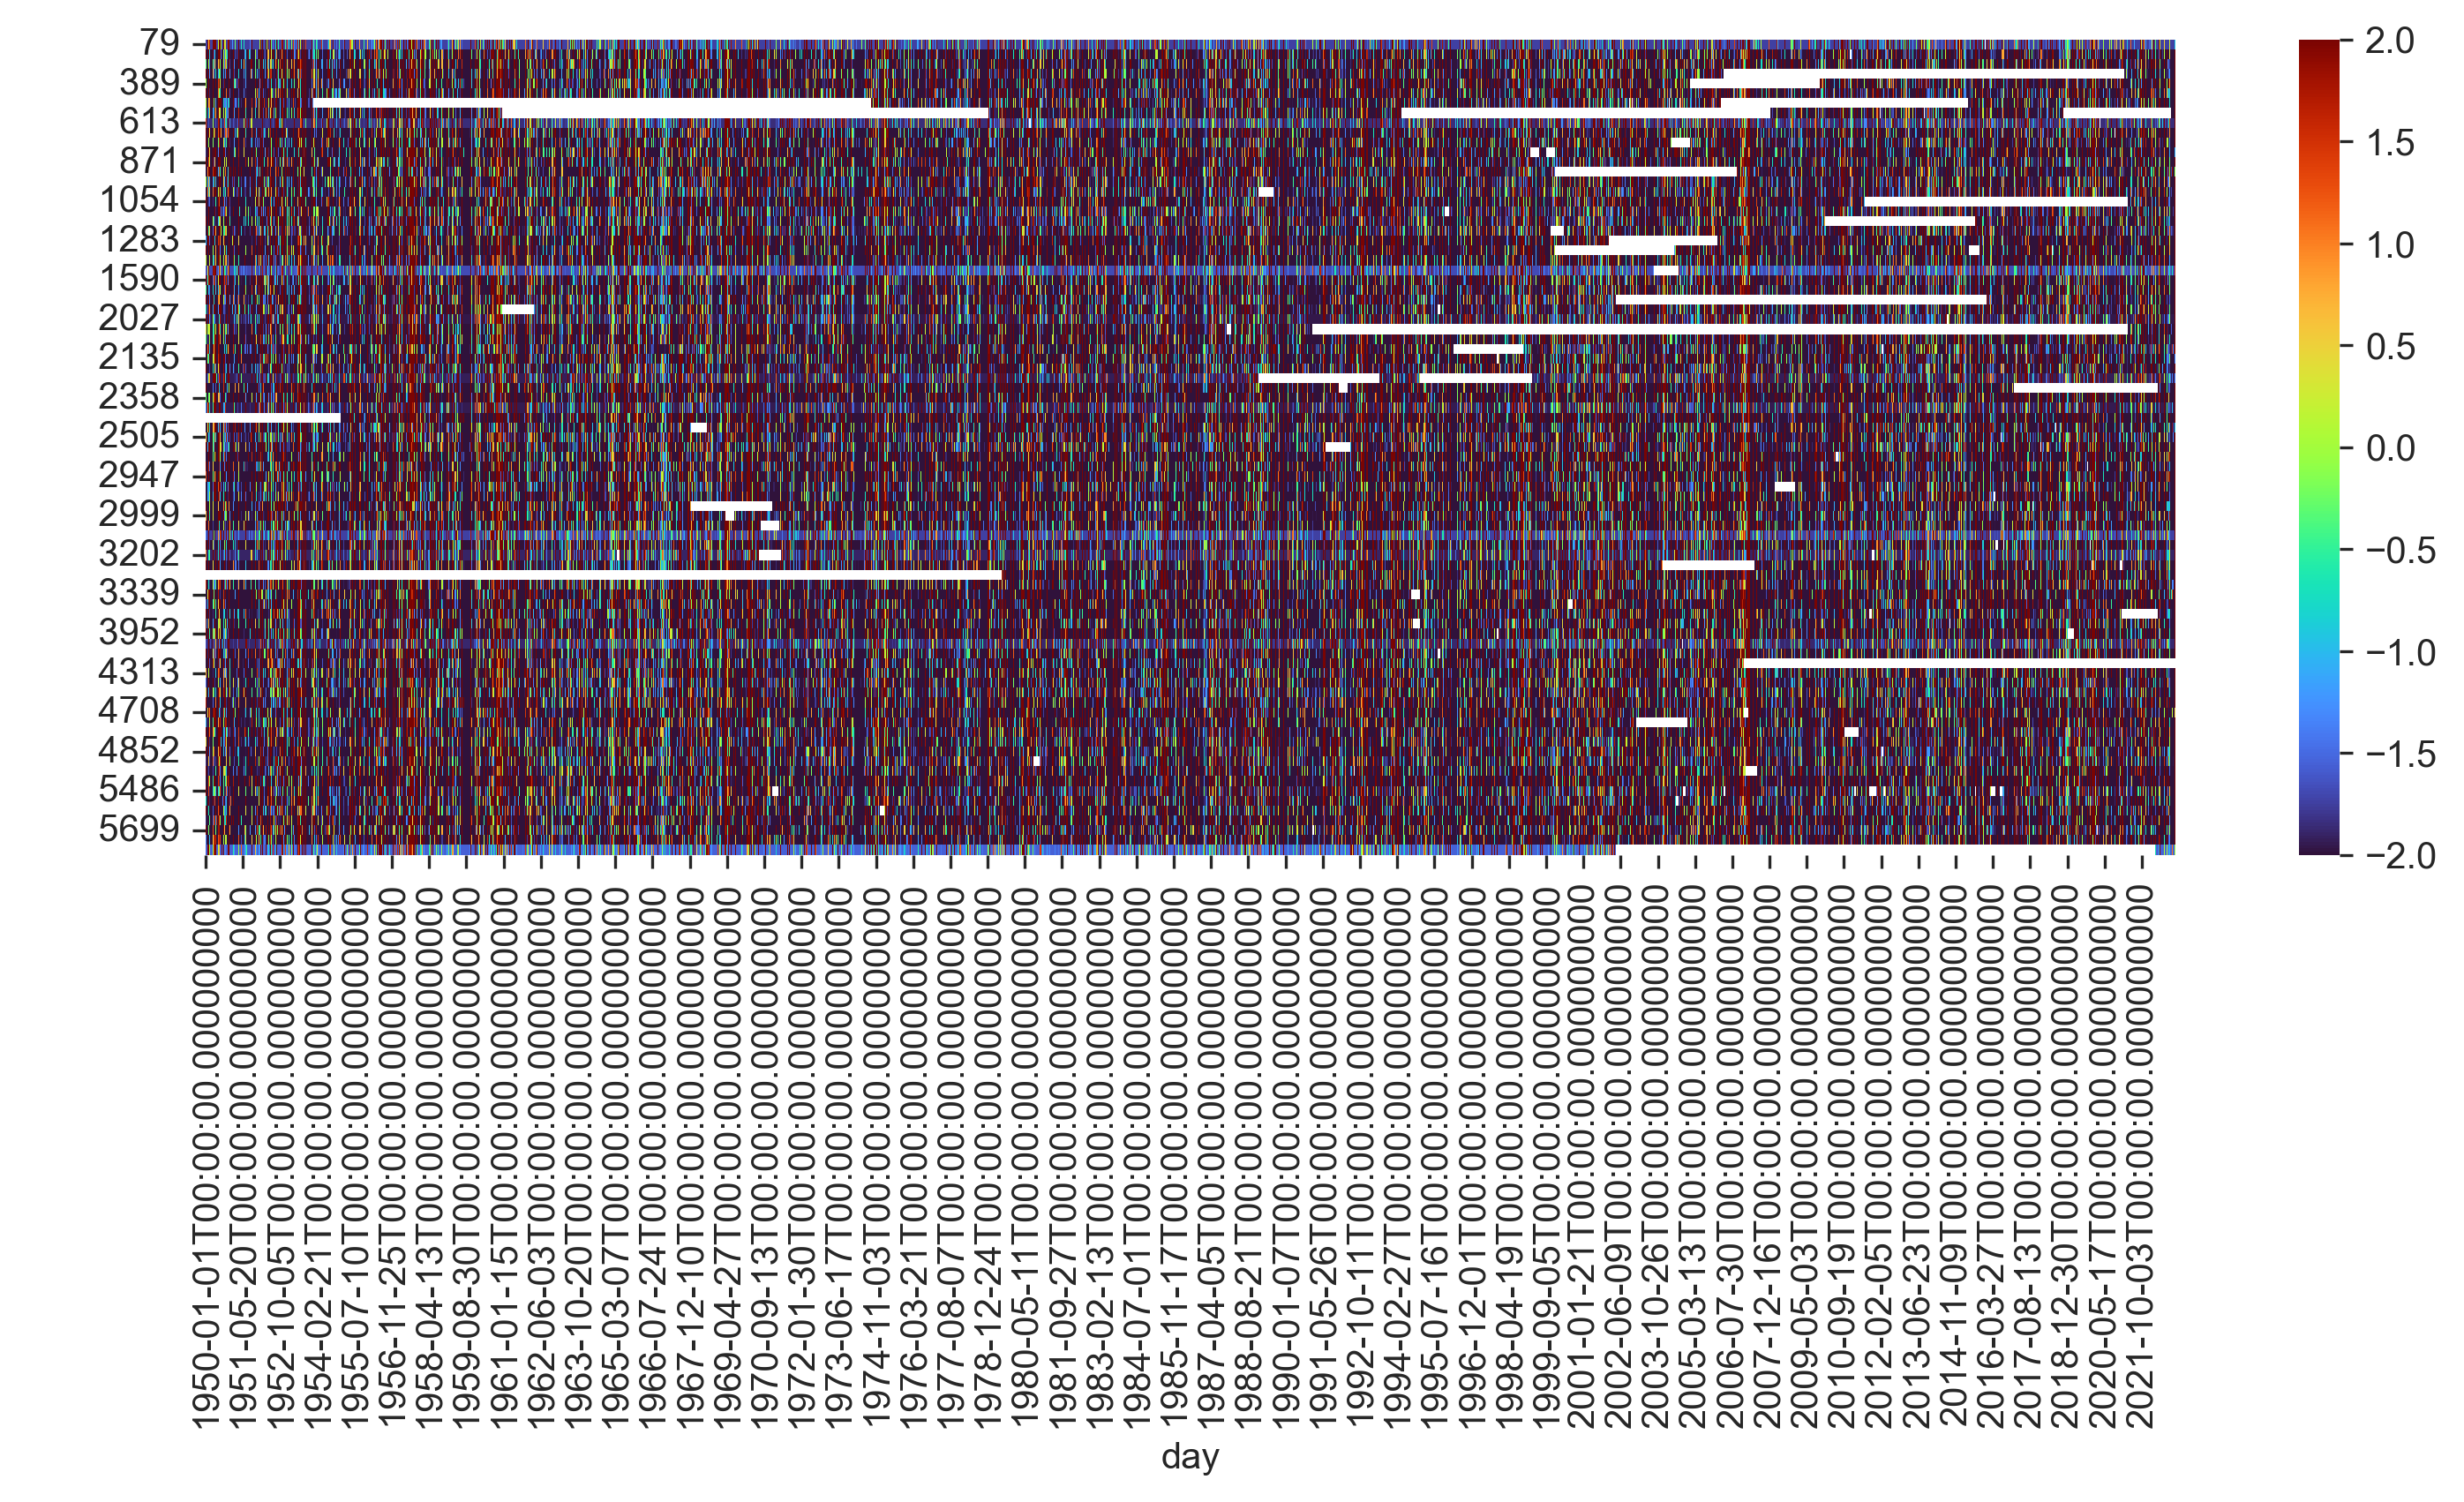

In [41]:
# 
sns.set_style('ticks')
fig3, ax3 = plt.subplots(dpi = 300, figsize = (12,4))

# Creates the heatmap of the temperature differences for the years between 1950 and 2022
# df_temp_diff.index >= 1950: Filters the DataFrame to include only rows with an index (year) greater than or equal to 1950
# df_temp_diff.index <= 2022: Filters the DataFrame to include only rows with an index (year) less than or equal to 2022
# T: Transposes the DataFrame so that years are on the x-axis and other dimensions (e.g., locations) are on the y-axis

sns.heatmap(df_prec_diff[(df_prec_diff.index.year >= 1950) & (df_prec_diff.index.year <= 2022)].T, cmap='turbo', vmin=-2, vmax=2, ax=ax3)
# cmap: Sets the color map to 'coolwarm'
# vmin and vmax: Set the color scale limits


fig3.savefig(r'../Images/Nordrhein_Westfalen_Annual_Prec_Diff_Stripes_FinalVersion.png')

# Question:

- Which tendency can you see in the temperature according the plot above?
- Why does station 555 display a different tendency than the other stations?